### 1. Importation des bibliothèques et configuration

In [1]:
# Cellule 1: Imports et configuration
import logging
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Pyspark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, input_file_name, regexp_replace, regexp_extract, split, element_at,
    avg, count, desc, asc, round as spark_round, countDistinct, collect_set, 
    abs, sum as spark_sum, lpad, udf
)
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType


# Configuration du logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### 2. Initialisation de la session Spark

In [2]:
from pyspark.sql import SparkSession
import logging

def init_spark():
    """
    Initialise la session Spark avec des options supplémentaires pour une meilleure performance.
    """
    logging.info("Initialisation de la session Spark avec configurations supplémentaires.")
    spark = SparkSession.builder \
        .appName("LoL Champions Analysis") \
        .master("local[*]") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()  # Assurez-vous d'avoir ceci
    return spark

# Création de la session Spark
spark = init_spark()


2024-10-21 15:41:38,057 - INFO - Initialisation de la session Spark avec configurations supplémentaires.


### 3. Chargement des données

In [3]:
# Cellule 3: Chargement des données
def load_files(spark, data_dir, max_files=None):
    """
    Charge les fichiers CSV depuis le répertoire spécifié et les combine en un DataFrame unique.
    """
    def process_file(file_path):
        df = spark.read.csv(file_path, header=True, inferSchema=True, sep=";")
        df = df.withColumn("file_name", input_file_name())
        df = df.withColumn("file_name_decoded", regexp_replace(col("file_name"), '%20', ' '))
        df = df.withColumn("base_file_name", element_at(split(col("file_name_decoded"), "[/\\\\]"), -1))
        df = df.withColumn("version", regexp_extract(col("base_file_name"), r"(\d+\.\d+)\.csv$", 1))
        return df

    try:
        # Récupération de la liste des fichiers CSV
        full_path = os.path.abspath(data_dir)
        csv_files = [os.path.join(full_path, f) for f in os.listdir(full_path) if f.endswith('.csv')]
        if max_files:
            csv_files = csv_files[:max_files]
        
        # Chargement et combinaison des DataFrames
        dataframes = [process_file(file_path) for file_path in csv_files]
        
        if not dataframes:
            return None
        
        # Commencer avec le premier DataFrame et itérer pour les unir un par un
        combined_df = dataframes[0]
        for df in dataframes[1:]:
            combined_df = combined_df.unionByName(df)
        
        return combined_df
    except Exception as e:
        logging.error(f"Erreur lors du chargement des fichiers : {e}")
        raise e

# Spécifiez le répertoire de données
data_dir = r"C:\Users\brice\Desktop\M2\M2_S1\Donnees_Massives\Projet_SPARK\League_of_PySpark\data"

# Chargement des données
df = load_files(spark, data_dir, max_files=10)

# Affichage du schéma et des premières lignes
if df:
    df.printSchema()
    df.show(5)


root
 |-- Name: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Role: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- Score: double (nullable = true)
 |-- Trend: double (nullable = true)
 |-- Win %: string (nullable = true)
 |-- Role %: string (nullable = true)
 |-- Pick %: string (nullable = true)
 |-- Ban %: string (nullable = true)
 |-- KDA: double (nullable = true)
 |-- file_name: string (nullable = false)
 |-- file_name_decoded: string (nullable = false)
 |-- base_file_name: string (nullable = true)
 |-- version: string (nullable = true)

+------+--------+----+----+-----+------+------+------+------+------+----+--------------------+--------------------+--------------------+-------+
|  Name|   Class|Role|Tier|Score| Trend| Win %|Role %|Pick %| Ban %| KDA|           file_name|   file_name_decoded|      base_file_name|version|
+------+--------+----+----+-----+------+------+------+------+------+----+--------------------+--------------------+--------

### 4. Nettoyage des données

In [4]:
# Cellule 4: Nettoyage des données
def clean_data(df):
    """
    Nettoie les données en convertissant les colonnes de pourcentage et en ajustant les types de données.
    """
    percentage_columns = ["Win %", "Role %", "Pick %", "Ban %"]
    for col_name in percentage_columns:
        df = df.withColumn(col_name, regexp_replace(col_name, "%", "").cast("double"))
    df = df.withColumn("Tier", col("Tier").cast("string"))
    return df

# Nettoyage du DataFrame
df = clean_data(df)

# Vérification du schéma après nettoyage
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Role: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- Score: double (nullable = true)
 |-- Trend: double (nullable = true)
 |-- Win %: double (nullable = true)
 |-- Role %: double (nullable = true)
 |-- Pick %: double (nullable = true)
 |-- Ban %: double (nullable = true)
 |-- KDA: double (nullable = true)
 |-- file_name: string (nullable = false)
 |-- file_name_decoded: string (nullable = false)
 |-- base_file_name: string (nullable = true)
 |-- version: string (nullable = true)



### 5. Statistiques globales :

In [5]:
# Cellule 5: Statistiques globales
def calculate_global_stats(df):
    """
    Calcule les statistiques globales sur les colonnes numériques.
    """
    numeric_cols = ["Score", "Trend", "Win %", "Role %", "Pick %", "Ban %", "KDA"]
    stats = df.select([avg(c).alias(f"avg_{c}") for c in numeric_cols])
    return stats

# Calcul des statistiques globales
global_stats = calculate_global_stats(df)
global_stats.show()

+-----------------+--------------------+-----------------+------------------+------------------+------------------+------------------+
|        avg_Score|           avg_Trend|        avg_Win %|        avg_Role %|        avg_Pick %|         avg_Ban %|           avg_KDA|
+-----------------+--------------------+-----------------+------------------+------------------+------------------+------------------+
|50.00001229508195|-0.10900819672131139|50.21902868852459|62.414139344262296|3.8984836065573782|5.3775327868852445|2.3298401639344264|
+-----------------+--------------------+-----------------+------------------+------------------+------------------+------------------+



### 6. Analyses par catégorie :

In [6]:
# Cellule 6: Analyses par catégorie
def calculate_categorical_stats(df, col_name):
    """
    Calcule les statistiques moyennes par catégorie pour une colonne donnée.
    """
    stats = df.groupBy(col_name).agg(
        avg("Win %").alias("avg_win_rate"),
        avg("Pick %").alias("avg_pick_rate"),
        avg("Ban %").alias("avg_ban_rate"),
        avg("KDA").alias("avg_kda")
    ).orderBy(desc("avg_win_rate"))
    return stats

# Colonnes catégorielles à analyser
categorical_cols = ["Class", "Role", "Tier"]

for col_name in categorical_cols:
    stats = calculate_categorical_stats(df, col_name)
    print(f"Statistiques par '{col_name}':")
    stats.show(truncate=False)


Statistiques par 'Class':
+--------+------------------+------------------+-----------------+------------------+
|Class   |avg_win_rate      |avg_pick_rate     |avg_ban_rate     |avg_kda           |
+--------+------------------+------------------+-----------------+------------------+
|Tank    |51.10532710280374 |3.083862928348909 |4.588598130841121|2.517570093457944 |
|Mage    |50.50792421746292 |2.7768039538714993|4.376474464579901|2.367561779242175 |
|Marksman|50.12710674157304 |6.352359550561797 |4.91384831460674 |2.221797752808988 |
|Support |50.11710659898477 |4.61730964467005  |3.94766497461929 |2.9026395939086287|
|Fighter |50.018549075391185|3.544523470839261 |5.627567567567566|2.095917496443812 |
|Assassin|49.1794921875     |4.5859765625      |9.79890625       |2.3568359375      |
+--------+------------------+------------------+-----------------+------------------+

Statistiques par 'Role':
+-------+-----------------+------------------+-----------------+------------------+
|Rol

### 7. Visualisation des fréquences des catégories :

Affichage des fréquences pour la colonne 'Class' :
+--------+-----+
|Class   |count|
+--------+-----+
|Fighter |703  |
|Mage    |607  |
|Marksman|356  |
|Tank    |321  |
|Assassin|256  |
|Support |197  |
+--------+-----+



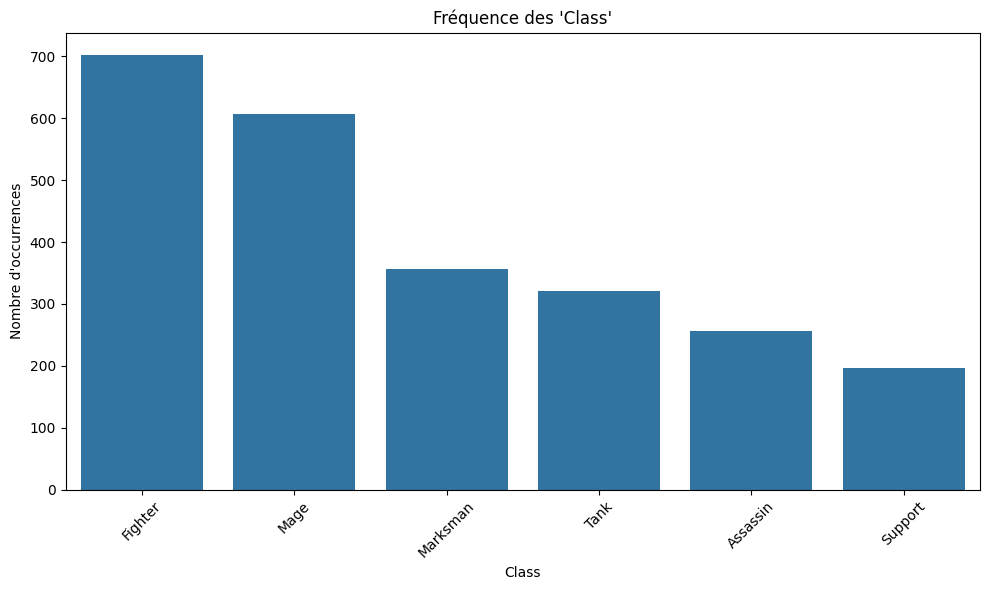

Affichage des fréquences pour la colonne 'Role' :
+-------+-----+
|Role   |count|
+-------+-----+
|MID    |619  |
|TOP    |611  |
|JUNGLE |482  |
|SUPPORT|470  |
|ADC    |258  |
+-------+-----+



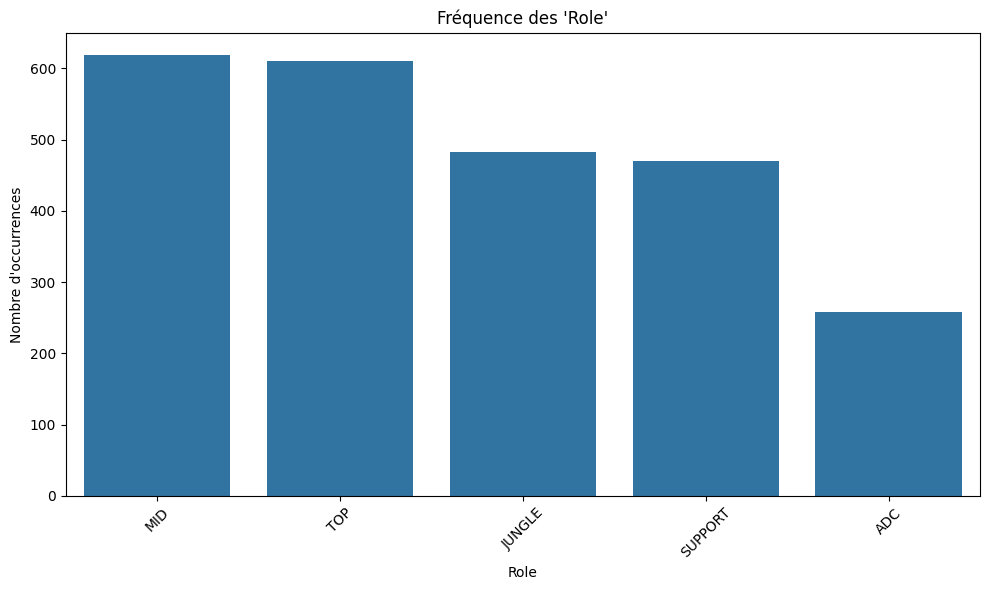

Affichage des fréquences pour la colonne 'Tier' :
+----+-----+
|Tier|count|
+----+-----+
|B   |611  |
|A   |610  |
|C   |366  |
|S   |364  |
|D   |250  |
|God |239  |
+----+-----+



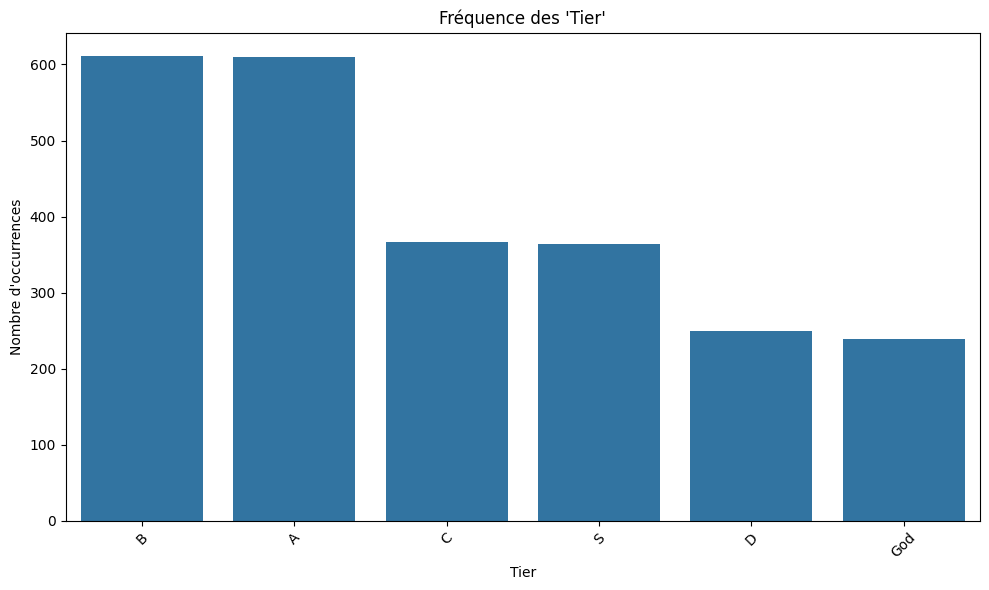

In [7]:
# Cellule 7: Visualisation des fréquences avec affichage natif et plot
def plot_categorical_frequency(df, col_name):
    """
    Génère un graphique de la fréquence des catégories pour une colonne donnée,
    et affiche également les données en utilisant PySpark DataFrame.
    """
    # Calculer les fréquences avec PySpark
    freq_spark = df.groupBy(col_name).count().orderBy(desc("count"))
    
    # Afficher les fréquences avec PySpark
    print(f"Affichage des fréquences pour la colonne '{col_name}' :")
    freq_spark.show(truncate=False)
    
    # Conversion en Pandas pour l'affichage avec matplotlib/seaborn
    freq_pandas = freq_spark.toPandas()
    
    # Générer le graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col_name, y='count', data=freq_pandas)
    plt.title(f"Fréquence des '{col_name}'")
    plt.xlabel(col_name)
    plt.ylabel("Nombre d'occurrences")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Parcourir les colonnes catégorielles et afficher les fréquences
for col_name in categorical_cols:
    plot_categorical_frequency(df, col_name)

### 8. Évolution des statistiques par version :

+-------+------------------+------------------+-----------------+
|version|      avg_win_rate|     avg_pick_rate|     avg_ban_rate|
+-------+------------------+------------------+-----------------+
|   13.1|  50.2306147540984| 3.940778688524591|5.479262295081966|
|   13.3| 50.00473029045642| 3.939958506224068|5.493734439834026|
|   13.4| 50.24514644351461|3.9702092050209212|5.516820083682005|
|   13.5| 50.09540650406506|3.8695528455284576|5.320406504065044|
|   13.6| 50.25378600823046| 3.903909465020578|5.226913580246913|
|   13.7| 50.23791666666666|3.9488333333333343|5.376083333333327|
|  13.10| 50.27983606557377|3.8950409836065543| 5.44954918032787|
|  13.11|50.268244897959185|3.8759591836734697|5.214408163265303|
|  13.12| 50.27143426294819| 3.797529880478088|5.401513944223105|
|  13.13| 50.29983805668016| 3.849716599190283|5.301659919028341|
+-------+------------------+------------------+-----------------+



2024-10-21 15:42:29,293 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-21 15:42:29,298 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-21 15:42:29,328 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-21 15:42:29,333 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-21 15:42:29,347 - INFO - Using categorical units to plot a list of strings that are all parsable as 

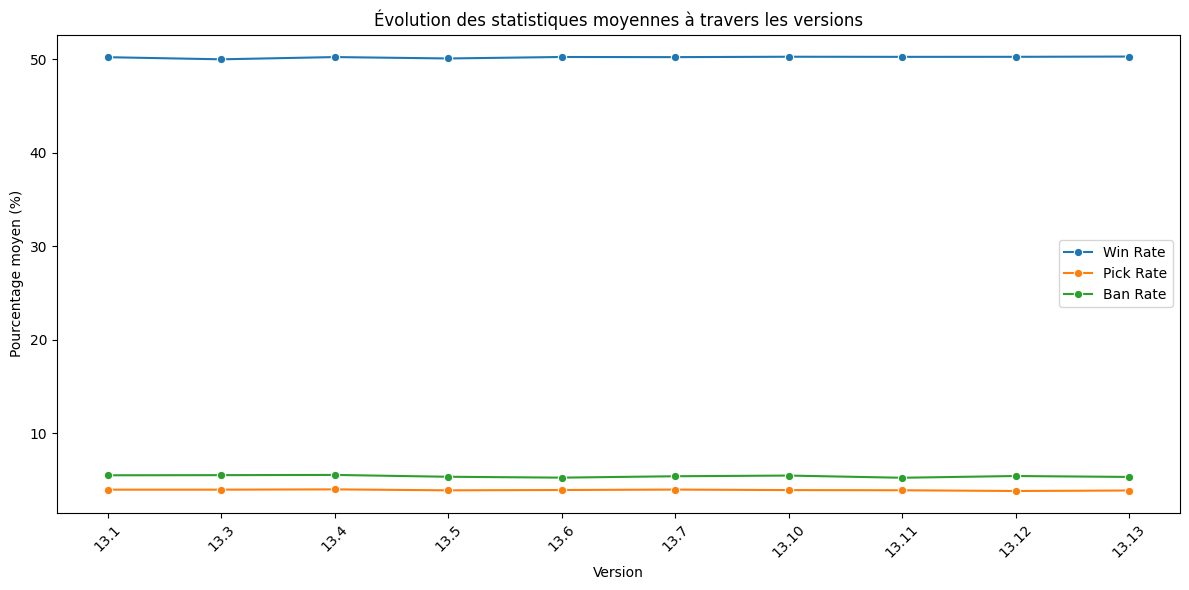

In [8]:
# Cellule 8: Évolution des statistiques par version avec tri correct
from pyspark.sql.functions import lpad

def calculate_version_stats(df):
    """
    Calcule les statistiques moyennes par version, avec un tri correct des versions.
    """
    # Ajouter une colonne version_patch pour trier correctement les versions (ajout de zéros pour 13.01, 13.02, etc.)
    df = df.withColumn("version_patch", lpad(col("version"), 5, "0"))
    
    # Calculer les statistiques groupées par version et version_patch
    stats = df.groupBy("version", "version_patch").agg(
        avg("Win %").alias("avg_win_rate"),
        avg("Pick %").alias("avg_pick_rate"),
        avg("Ban %").alias("avg_ban_rate")
    ).orderBy("version_patch")  # Trier par version_patch
    
    return stats

# Calcul des statistiques par version
version_stats = calculate_version_stats(df)
version_stats.select("version", "avg_win_rate", "avg_pick_rate", "avg_ban_rate").show()

# Visualisation de l'évolution des statistiques
def plot_version_stats(version_stats):
    """
    Génère un graphique de l'évolution des statistiques moyennes à travers les versions.
    """
    version_stats_pd = version_stats.toPandas()
    
    # Tracer les données
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='version', y='avg_win_rate', data=version_stats_pd, marker='o', label='Win Rate')
    sns.lineplot(x='version', y='avg_pick_rate', data=version_stats_pd, marker='o', label='Pick Rate')
    sns.lineplot(x='version', y='avg_ban_rate', data=version_stats_pd, marker='o', label='Ban Rate')
    
    # Paramètres du graphique
    plt.title("Évolution des statistiques moyennes à travers les versions")
    plt.xlabel("Version")
    plt.ylabel("Pourcentage moyen (%)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Affichage du graphique
plot_version_stats(version_stats)

### 9. Analyses avancées :

#### a. Champions polyvalents :

In [9]:
# Cellule 9a: Analyse des champions polyvalents
def analyze_polyvalent_champions(df):
    """
    Identifie les champions jouant dans plusieurs rôles.
    """
    polyvalent = df.groupBy("Name").agg(
        countDistinct("Role").alias("role_count"),
        collect_set("Role").alias("roles")
    ).orderBy(desc("role_count"))
    return polyvalent

# Analyse des champions polyvalents
polyvalent_champions = analyze_polyvalent_champions(df)
polyvalent_champions.show(10, truncate=False)

+------------+----------+---------------------------+
|Name        |role_count|roles                      |
+------------+----------+---------------------------+
|Heimerdinger|4         |[ADC, MID, SUPPORT, TOP]   |
|Neeko       |4         |[JUNGLE, MID, SUPPORT, TOP]|
|Pantheon    |4         |[JUNGLE, MID, SUPPORT, TOP]|
|Ivern       |3         |[JUNGLE, SUPPORT, TOP]     |
|Karthus     |3         |[ADC, JUNGLE, MID]         |
|Taliyah     |3         |[JUNGLE, MID, SUPPORT]     |
|Malphite    |3         |[MID, SUPPORT, TOP]        |
|Rumble      |3         |[JUNGLE, MID, TOP]         |
|Swain       |3         |[ADC, MID, SUPPORT]        |
|Seraphine   |3         |[ADC, MID, SUPPORT]        |
+------------+----------+---------------------------+
only showing top 10 rows



#### b. Évolution du taux de victoire et d'autres statistiques des champions à travers les patchs :

In [10]:
# Cellule 9b: Évolution du taux de victoire et des autres statistiques des champions avec tri correct des versions
def analyze_win_rate_evolution(df):
    """
    Analyse l'évolution des statistiques des champions (winrate, pickrate, banrate, trend) au fil des versions.
    """
    # Ajouter un champ version_patch pour garantir un tri correct des versions en ajoutant un zéro à gauche si nécessaire
    df = df.withColumn("version_patch", lpad(col("version"), 5, "0"))
    
    # Sélectionner les colonnes d'intérêt et agréger les valeurs numériques par nom et version
    evolution_stats = df.groupBy("Name", "version", "version_patch", "Tier").agg(
        avg("Win %").alias("avg_win_rate"),
        avg("Pick %").alias("avg_pick_rate"),
        avg("Ban %").alias("avg_ban_rate"),
        avg("Trend").alias("avg_trend")
    ).orderBy("Name", "version_patch")  # Trier d'abord par nom, ensuite par version_patch
    
    return evolution_stats

# Calcul de l'évolution des statistiques
evolution_stats = analyze_win_rate_evolution(df)
evolution_stats.select("Name", "version", "Tier", "avg_win_rate", "avg_pick_rate", "avg_ban_rate", "avg_trend").show(20, truncate=False)

+------+-------+----+------------+-------------+------------+---------+
|Name  |version|Tier|avg_win_rate|avg_pick_rate|avg_ban_rate|avg_trend|
+------+-------+----+------------+-------------+------------+---------+
|Aatrox|13.1   |S   |47.68       |6.62         |11.98       |-31.86   |
|Aatrox|13.3   |A   |48.17       |5.14         |6.6         |0.0      |
|Aatrox|13.4   |A   |47.27       |4.7          |5.57        |-2.38    |
|Aatrox|13.5   |A   |46.86       |5.15         |5.83        |2.78     |
|Aatrox|13.6   |A   |47.93       |5.09         |5.03        |-0.83    |
|Aatrox|13.7   |A   |47.49       |4.55         |4.57        |-3.98    |
|Aatrox|13.10  |S   |49.51       |5.55         |4.48        |2.26     |
|Aatrox|13.11  |God |47.85       |7.96         |5.0         |14.42    |
|Aatrox|13.12  |God |48.62       |7.48         |5.38        |-4.26    |
|Aatrox|13.13  |God |48.84       |7.01         |5.81        |-3.39    |
|Ahri  |13.1   |S   |49.5        |5.81         |1.73        |4.5

#### c. Taux de présence des champions suivant le patch :

In [11]:
# Cellule 9c: Taux de présence
def analyze_presence_rate(df):
    """
    Analyse le taux de présence (somme du taux de sélection et de bannissement) pour chaque champion.
    """
    # Calculer le taux de présence comme la somme de Pick % et Ban %
    presence_df = df.withColumn(
        "Presence %",
        col("Pick %") + col("Ban %")
    ).orderBy(desc("Presence %"))  # Trier par taux de présence décroissant
    return presence_df

# Calcul du taux de présence
presence_rate_df = analyze_presence_rate(df)

# Affichage du nom, version, pick %, ban %, presence %, tier, score et winrate
presence_rate_df.select("Name", "version", "Pick %", "Ban %", "Presence %", "Win %", "Tier", "Score").show(10, truncate=False)


+------------+-------+------+-----+------------------+-----+----+-----+
|Name        |version|Pick %|Ban %|Presence %        |Win %|Tier|Score|
+------------+-------+------+-----+------------------+-----+----+-----+
|Aurelion Sol|13.3   |21.06 |51.38|72.44             |51.16|God |92.92|
|Aurelion Sol|13.4   |12.51 |53.64|66.15             |53.31|God |94.54|
|Aurelion Sol|13.5   |10.39 |48.11|58.5              |52.33|God |94.06|
|Milio       |13.6   |24.37 |28.86|53.230000000000004|50.75|God |94.08|
|Kha'Zix     |13.11  |13.4  |38.5 |51.9              |50.94|God |93.62|
|Yuumi       |13.5   |15.57 |35.99|51.56             |50.84|God |96.63|
|Kha'Zix     |13.10  |16.27 |35.14|51.41             |51.92|God |94.75|
|Zed         |13.1   |10.0  |36.9 |46.9              |48.68|God |88.26|
|Milio       |13.11  |14.25 |31.92|46.17             |52.52|God |95.96|
|Kassadin    |13.1   |7.72  |36.28|44.0              |52.3 |God |88.29|
+------------+-------+------+-----+------------------+-----+----

### 10. UDF pour calcul d'un custom_score visant à imiter le score existant

In [26]:
# Cellule 10: UDF custom_score

# Définir une fonction UDF qui inclut le Ban %
def calculate_custom_score(kda, win_rate, pick_rate, ban_rate):
    return (kda * 0.3) + (win_rate * 0.5) + (pick_rate * 0.15) + (ban_rate * 0.05)

# Créer l'UDF
custom_score_udf = udf(calculate_custom_score, DoubleType())

# Convertir les colonnes en types numériques avant d'appliquer l'UDF
df = df.withColumn("KDA", col("KDA").cast("double"))
df = df.withColumn("Win %", col("Win %").cast("double"))
df = df.withColumn("Pick %", col("Pick %").cast("double"))
df = df.withColumn("Ban %", col("Ban %").cast("double"))

# Appliquer l'UDF avec le Ban %
df = df.withColumn("custom_score", custom_score_udf(col("KDA"), col("Win %"), col("Pick %"), col("Ban %")))

# Afficher le premier tableau trié par custom_score décroissant
print("===== Tableau trié par custom_score décroissant =====")
df.select("Name", "version", "Tier", "KDA", "Win %", "Pick %", "Ban %", "Score", "custom_score") \
  .orderBy(desc("custom_score")) \
  .show(10)

# Afficher le second tableau trié par Score décroissant
print("===== Tableau trié par Score décroissant =====")
df.select("Name", "version", "Tier", "KDA", "Win %", "Pick %", "Ban %", "Score", "custom_score") \
  .orderBy(desc("Score")) \
  .show(10)

# Afficher le troisième tableau trié par custom_score croissant
print("===== Tableau trié par custom_score croissant =====")
df.select("Name", "version", "Tier", "KDA", "Win %", "Pick %", "Ban %", "Score", "custom_score") \
  .orderBy(asc("custom_score")) \
  .show(10)

# Afficher le quatrième tableau trié par Score croissant
print("===== Tableau trié par Score croissant =====")
df.select("Name", "version", "Tier", "KDA", "Win %", "Pick %", "Ban %", "Score", "custom_score") \
  .orderBy(asc("Score")) \
  .show(10)

===== Tableau trié par custom_score décroissant =====
+------------+-------+----+----+-----+------+-----+-----+------------------+
|        Name|version|Tier| KDA|Win %|Pick %|Ban %|Score|      custom_score|
+------------+-------+----+----+-----+------+-----+-----+------------------+
|Aurelion Sol|   13.3| God|2.54|51.16| 21.06|51.38|92.92|             32.07|
|Aurelion Sol|   13.4| God|2.73|53.31| 12.51|53.64|94.54|           32.0325|
|       Milio|   13.6| God|3.23|50.75| 24.37|28.86|94.08|31.442500000000003|
|      Kai'Sa|  13.13| God|2.48| 51.4| 28.67|11.96|92.98|31.342499999999998|
|       Milio|  13.11| God|3.53|52.52| 14.25|31.92|95.96|31.052500000000002|
|     Kha'Zix|  13.10| God|2.67|51.92| 16.27|35.14|94.75|           30.9585|
|Aurelion Sol|   13.5| God|2.67|52.33| 10.39|48.11|94.06|30.929999999999996|
|       Yuumi|   13.5| God|4.54|50.84| 15.57|35.99|96.63|            30.917|
|      Maokai|   13.1| God|3.02|54.31|  9.84| 27.5|97.26|            30.912|
|        Jinx|   13.7|

### Arrêt de la session Spark :

In [56]:
# Cellule finale: Arrêt de Spark
# spark.stop()